In [1]:
!pip install torchdiffeq

In [4]:
import os
import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io
from torchdiffeq import odeint

# Устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

os.makedirs('./results_xnode/', exist_ok=True)


# =============================
# XNODE Block (векторизованный)
# =============================
class XNODEBlock(nn.Module):
    def __init__(self, dim, hidden_dim=40, hidden_layers=2, output_dim=1, solver='midpoint', t0=0.0, t1=1.0):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.t0 = t0
        self.t1 = t1
        self.solver = solver

        self.initial_net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        ).double()

        in_dim = hidden_dim + 1 + dim
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.vector_field = nn.Sequential(*layers).double()

        self.decoder = nn.Linear(hidden_dim, output_dim).double()

    def forward(self, x_with_t):
        x = x_with_t[:, :-1]      # [N, dim]
        t_target = x_with_t[:, -1]  # [N]

        u_vals = []
        for i in range(x.shape[0]):
            t_i = t_target[i].item()
            x_i = x[i:i+1]  # [1, dim]

            if abs(t_i - self.t0) < 1e-8:
                h0 = self.initial_net(x_i.double())
                u_i = self.decoder(h0)
            else:
                h0 = self.initial_net(x_i.double())
                t_span = torch.tensor([self.t0, t_i], device=x.device, dtype=torch.float64)

                def odefunc(t, h):
                    t_in = t.view(1, 1)
                    inp = torch.cat([h, t_in, x_i.double()], dim=1)
                    return self.vector_field(inp)

                h_final = odeint(odefunc, h0, t_span, method=self.solver)[-1]
                u_i = self.decoder(h_final)

            u_vals.append(u_i)

        return torch.cat(u_vals, dim=0)  # [N, 1]


# =============================
# Сеть v (остаётся MLP)
# =============================
class NetV(nn.Module):
    def __init__(self, input_dim, output_dim, layers, hidden_size):
        super(NetV, self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_dim, hidden_size)
        self.h_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(layers)])
        self.output_layer = nn.Linear(hidden_size, output_dim)
        self.activation_tanh = nn.Tanh()
        self.activation_softplus = nn.Softplus()

    def forward(self, x):
        hi = self.activation_tanh(self.input_layer(x))
        for i, layer in enumerate(self.h_layers):
            if i % 2 == 0:
                hi = self.activation_softplus(layer(hi))
            else:
                hi = torch.sin(layer(hi))
        return self.output_layer(hi)


# =============================
# Основной решатель (XNODE-WAN)
# =============================
class ParabolicWanPDESolver(nn.Module):
    def __init__(self, dim, N_x, N_t, N_bd, file_path,
                 beta_int=100.0, beta_intw=500.0, beta_bd=1000.0,
                 v_step=1, v_rate=0.015, u_step=1, u_rate=0.015,
                 u_hidden_dim=40, u_hidden_layers=2,
                 iteration=20001, device='cuda'):
        super().__init__()
        self.device = device
        self.dim = dim
        self.t0, self.t1 = 0.0, 1.0
        self.low, self.up = -1.0, 1.0
        self.iteration = iteration
        self.dir = file_path

        # Параметры точного решения
        self.la = np.pi / 2
        self.pho = 2.0
        self.mu = self.la**2 - 1

        # Размеры сэмплирования
        self.N_x = N_x
        self.N_t = N_t
        self.N_bd = N_bd

        # Потери
        self.beta_int = beta_int
        self.beta_intw = beta_intw
        self.beta_bd = beta_bd
        self.u_step = u_step
        self.v_step = v_step

        # Сети
        self.net_u = XNODEBlock(
            dim=dim,
            hidden_dim=u_hidden_dim,
            hidden_layers=u_hidden_layers,
            output_dim=1,
            solver='midpoint',
            t0=self.t0,
            t1=self.t1
        ).to(device)

        self.net_v = NetV(dim + 1, 1, layers=6, hidden_size=40).to(device)

        self.optimizer_u = torch.optim.Adam(self.net_u.parameters(), lr=u_rate)
        self.optimizer_v = torch.optim.Adagrad(self.net_v.parameters(), lr=v_rate)

        print(f"XNODE-WAN initialized: dim={dim}, N_x={N_x}, N_t={N_t}")

    def sample_train(self, N_x, N_t, N_bd):
        low, up, t0, t1 = self.low, self.up, self.t0, self.t1

        # Сэмплируем пространственные и временные точки отдельно
        x_spatial = np.random.uniform(low, up, (N_x, self.dim))  # [N_x, dim]
        t_temporal = np.linspace(t0, t1, N_t)                   # [N_t]

        # Декартово произведение: [N_x * N_t, dim+1]
        x_dm_list = []
        for t in t_temporal:
            for x in x_spatial:
                x_dm_list.append(np.concatenate([x, [t]]))
        x_dm_full = np.array(x_dm_list)

        # f(x,t) = μu - u²
        u_exact = self.pho * np.sin(self.la * x_dm_full[:, 0:1]) * np.exp((self.mu - self.la**2) * x_dm_full[:, -1:])
        f_dm = self.mu * u_exact - u_exact**2

        # Начальные условия (t = t0)
        x_init = np.random.uniform(low, up, (N_bd, self.dim))
        t_init = np.full((N_bd, 1), t0)
        x_init_full = np.concatenate([x_init, t_init], axis=1)
        u_init = self.pho * np.sin(self.la * x_init[:, 0:1]) * np.exp((self.mu - self.la**2) * t0)
        u_init = u_init.reshape(-1, 1)

        # Конечные точки (t = t1)
        x_right = np.random.uniform(low, up, (N_bd, self.dim))
        t_right = np.full((N_bd, 1), t1)
        x_right_full = np.concatenate([x_right, t_right], axis=1)

        # Граничные точки
        x_bd_list = []
        for i in range(self.dim):
            x_bound = np.random.uniform(low, up, (N_bd, self.dim))
            t_bound = np.random.uniform(t0, t1, (N_bd, 1))
            x_bound[:, i] = up
            x_bd_list.append(np.concatenate([x_bound, t_bound], axis=1))
            x_bound = np.random.uniform(low, up, (N_bd, self.dim))
            x_bound[:, i] = low
            x_bd_list.append(np.concatenate([x_bound, t_bound], axis=1))
        x_bd = np.concatenate(x_bd_list, axis=0)
        u_bd = self.pho * np.sin(self.la * x_bd[:, 0:1]) * np.exp((self.mu - self.la**2) * x_bd[:, -1:])
        u_bd = u_bd.reshape(-1, 1)

        # В тензоры
        to_t = lambda x: torch.FloatTensor(x).to(self.device)
        return {
            'x_dm': to_t(x_dm_full),
            'x_init': to_t(x_init_full),
            'x_right': to_t(x_right_full),
            'x_bd': to_t(x_bd),
            'f_val': to_t(f_dm),
            'u_init': to_t(u_init),
            'u_bd': to_t(u_bd)
        }

    def sample_test(self, N_test=5000):
        x_test = np.random.uniform(self.low, self.up, (N_test, self.dim))
        t_test = np.random.uniform(self.t0, self.t1, (N_test, 1))
        x_test_full = np.concatenate([x_test, t_test], axis=1)
        u_exact = self.pho * np.sin(self.la * x_test[:, 0:1]) * np.exp((self.mu - self.la**2) * t_test)
        u_exact = u_exact.reshape(-1, 1)
        return {
            'test_x': torch.FloatTensor(x_test_full).to(self.device),
            'test_u': torch.FloatTensor(u_exact).to(self.device)
        }

    def fun_w(self, x):
        I1 = 0.210987
        x_list = torch.split(x, 1, dim=1)
        h_len = (self.up - self.low) / 2.0
        x_scale_list = [(x_i - self.low - h_len) / h_len for x_i in x_list]
        z_x_list = []
        for xs in x_scale_list:
            supp = (1 - torch.abs(xs)) > 0
            denom = xs ** 2 - 1
            safe_denom = torch.where(supp, denom, torch.ones_like(denom))
            z_x = torch.where(supp, torch.exp(1.0 / safe_denom) / I1, torch.zeros_like(xs))
            z_x_list.append(z_x)
        w_val = torch.ones_like(z_x_list[0])
        for z in z_x_list:
            w_val = w_val * z
        if x.requires_grad:
            dw = torch.autograd.grad(w_val, x, grad_outputs=torch.ones_like(w_val),
                                    create_graph=True, allow_unused=False)[0]
            dw = torch.where(torch.isnan(dw), torch.zeros_like(dw), dw)
        else:
            dw = torch.zeros_like(x)
        return w_val, dw

    def grad_u(self, x_in):
        x_in = x_in.detach().requires_grad_(True)
        u_val = self.net_u(x_in)
        grad_u = torch.autograd.grad(u_val, x_in, grad_outputs=torch.ones_like(u_val),
                                    create_graph=True, retain_graph=True)[0]
        return u_val, grad_u

    def grad_v(self, x_in):
        x_in = x_in.detach().requires_grad_(True)
        v_val = self.net_v(x_in)
        grad_v = torch.autograd.grad(v_val, x_in, grad_outputs=torch.ones_like(v_val),
                                    create_graph=True, retain_graph=True)[0]
        return v_val, grad_v

    def compute_loss(self, train_dict):
        x_dm = train_dict['x_dm']
        x_init = train_dict['x_init']
        x_right = train_dict['x_right']
        x_bd = train_dict['x_bd']
        f_val = train_dict['f_val']
        u_init_true = train_dict['u_init']
        u_bd_true = train_dict['u_bd']

        u_val, grad_u = self.grad_u(x_dm)
        v_val, grad_v = self.grad_v(x_dm)
        grad_u_x = grad_u[:, :-1]; grad_u_t = grad_u[:, -1:]
        grad_v_x = grad_v[:, :-1]; grad_v_t = grad_v[:, -1:]

        w_val, grad_w = self.fun_w(x_dm[:, :-1])
        wv_val = w_val * v_val

        dudw_val = torch.sum(grad_u_x * grad_w, dim=1, keepdim=True)
        dudv_val = torch.sum(grad_u_x * grad_v_x, dim=1, keepdim=True)
        dudwv_val = v_val * dudw_val + w_val * dudv_val
        u_w_dvt_val = u_val * w_val * grad_v_t
        uu_wv_val = u_val * u_val * wv_val
        f_wv_val = f_val * wv_val

        u_init_pred, _ = self.grad_u(x_init)
        u_right_pred, _ = self.grad_u(x_right)
        w_init, _ = self.fun_w(x_init[:, :-1])
        w_right, _ = self.fun_w(x_right[:, :-1])
        v_init, _ = self.grad_v(x_init)
        v_right, _ = self.grad_v(x_right)

        uwv_init = torch.mean(u_init_pred * w_init * v_init)
        uwv_right = torch.mean(u_right_pred * w_right * v_right)

        term1 = uwv_right
        term2 = torch.mean(dudwv_val)
        term3 = torch.mean(u_w_dvt_val)
        term4 = uwv_init
        term5 = torch.mean(uu_wv_val)
        term6 = torch.mean(f_wv_val)

        residual = (term1 + term2 - term3) - (term4 + term5 + term6)
        test_norm = torch.mean(wv_val**2) + 1e-8
        loss_int = self.beta_int * (residual ** 2) / test_norm

        # Вспомогательный
        uw_init = torch.mean(u_init_pred * w_init)
        uw_right = torch.mean(u_right_pred * w_right)
        dudw_aux = torch.mean(dudw_val)
        uu_w_aux = torch.mean(u_val * u_val * w_val)
        f_w_aux = torch.mean(f_val * w_val)
        residual_w = (uw_right + dudw_aux) - (uw_init + uu_w_aux + f_w_aux)
        w_norm = torch.mean(w_val**2) + 1e-8
        loss_intw = self.beta_intw * (residual_w ** 2) / w_norm

        loss_bd = torch.mean(torch.abs(self.net_u(x_bd) - u_bd_true))
        loss_init = torch.mean(torch.abs(u_init_pred - u_init_true))

        loss_u = self.beta_bd * (loss_bd + loss_init) + loss_int + loss_intw
        loss_v = -torch.log(loss_int + 1e-8)

        return loss_u, loss_v, loss_int, loss_bd, loss_init

    def train(self):
        history = {'step': [], 'loss_u': [], 'loss_v': [], 'l2r': []}
        test_dict = self.sample_test()

        for i in range(self.iteration):
            train_dict = self.sample_train(self.N_x, self.N_t, self.N_bd)
            loss_u, loss_v, loss_int, loss_bd, loss_init = self.compute_loss(train_dict)

            # Обучение v
            for _ in range(self.v_step):
                self.optimizer_v.zero_grad()
                _, loss_v, _, _, _ = self.compute_loss(train_dict)
                loss_v.backward()
                self.optimizer_v.step()

            # Обучение u
            for _ in range(self.u_step):
                self.optimizer_u.zero_grad()
                loss_u, _, _, _, _ = self.compute_loss(train_dict)
                loss_u.backward()
                self.optimizer_u.step()

            # Логирование
            if i % 1 == 0:
                with torch.no_grad():
                    pred_u = self.net_u(test_dict['test_x'])
                    test_u = test_dict['test_u']
                    err_l2 = torch.sqrt(torch.mean((test_u - pred_u)**2)).item()
                    u_norm = torch.sqrt(torch.mean(test_u**2)).item()
                    l2r = err_l2 / (u_norm + 1e-8)

                    history['step'].append(i)
                    history['loss_u'].append(loss_u.item())
                    history['loss_v'].append(loss_v.item())
                    history['l2r'].append(l2r)

                if i % 1 == 0:
                    print(f"Iter {i:6d} | L2r: {l2r:.6f} | Loss_u: {loss_u.item():.4f}")

        return history, test_dict


# =============================
# Запуск
# =============================
if __name__ == '__main__':
    dim = 5
    demo = ParabolicWanPDESolver(
        dim=dim,
        N_x=400,      # Пространственные точки
        N_t=20,       # Временные точки
        N_bd=400,     # Граничные точки
        file_path='./results_xnode/',
        beta_int=100.0,
        beta_intw=500.0,
        beta_bd=1000.0,
        v_step=1,
        v_rate=0.015,
        u_step=1,
        u_rate=0.015,  # Как в статье
        u_hidden_dim=40,
        u_hidden_layers=2,
        iteration=20,
        device=device
    )

    history, test_dict = demo.train()

    # Сохранение
    torch.save(demo.net_u.state_dict(), './results_xnode/net_u_xnode.pth')
    scipy.io.savemat('./results_xnode/history_xnode.mat', history)
    print("XNODE-WAN training completed and saved.")

Using device: cuda
XNODE-WAN initialized: dim=5, N_x=400, N_t=20
Iter      0 | L2r: 0.721830 | Loss_u: 2203.2316
Iter      1 | L2r: 0.509362 | Loss_u: 1700.0572
Iter      2 | L2r: 0.438334 | Loss_u: 1186.0946
Iter      3 | L2r: 0.374496 | Loss_u: 929.8965
Iter      4 | L2r: 0.392605 | Loss_u: 580.7442
Iter      5 | L2r: 0.271800 | Loss_u: 555.2215
Iter      6 | L2r: 0.303263 | Loss_u: 493.0153
Iter      7 | L2r: 0.432979 | Loss_u: 421.4119
Iter      8 | L2r: 0.310827 | Loss_u: 503.1608
Iter      9 | L2r: 0.260145 | Loss_u: 426.2509
Iter     10 | L2r: 0.228553 | Loss_u: 422.4112
Iter     11 | L2r: 0.200893 | Loss_u: 532.4587
Iter     12 | L2r: 0.256661 | Loss_u: 405.4399
Iter     13 | L2r: 0.246634 | Loss_u: 424.0855
Iter     14 | L2r: 0.189094 | Loss_u: 438.4756
Iter     15 | L2r: 0.189012 | Loss_u: 364.8150
Iter     16 | L2r: 0.211211 | Loss_u: 447.1796
Iter     17 | L2r: 0.291854 | Loss_u: 453.0399
Iter     18 | L2r: 0.347453 | Loss_u: 431.0902
Iter     19 | L2r: 0.303793 | Loss_u: 4

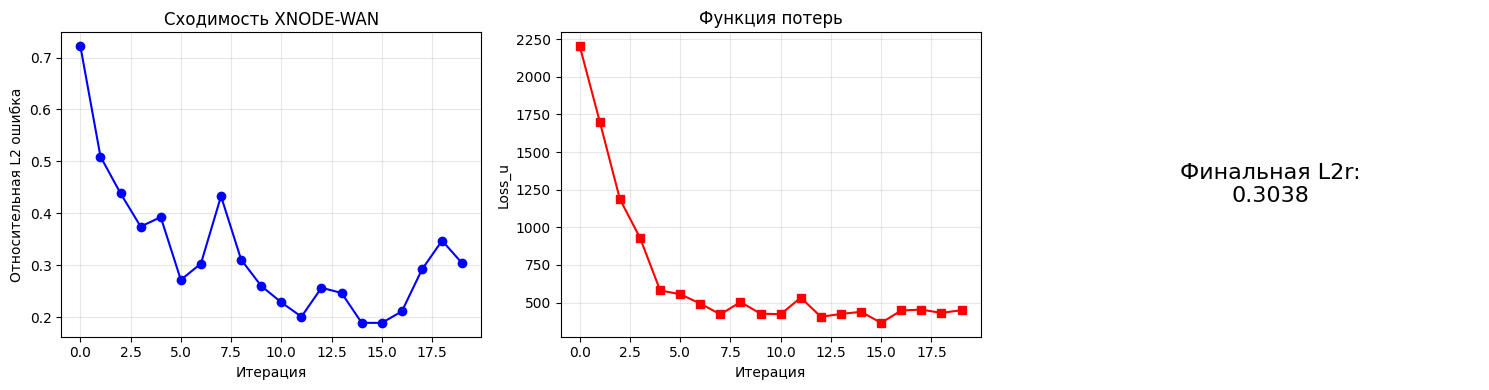

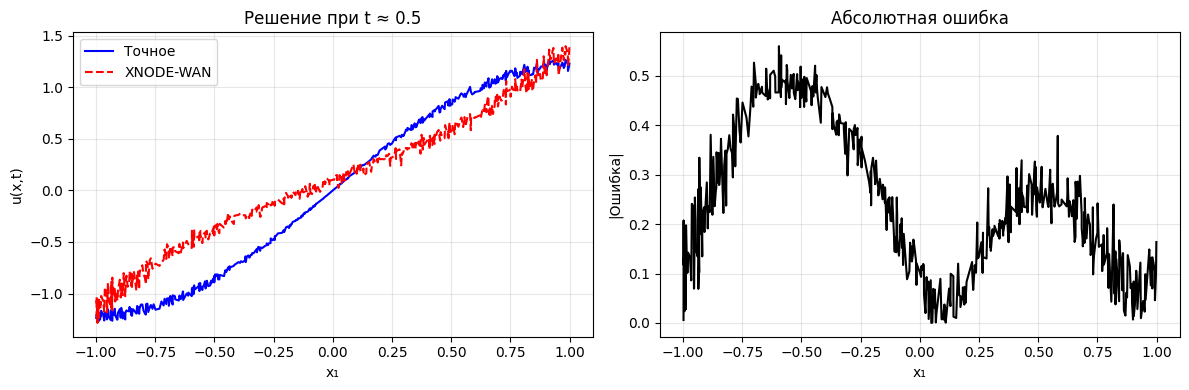

РЕЗУЛЬТАТЫ XNODE-WAN
Число итераций:      19
Финальная L2r:       0.3038
Минимальная L2r:     0.1890


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.io

# Загрузка (если нужно из файла)
# history = scipy.io.loadmat('./results_xnode/history_xnode.mat')
# Но у вас он уже в памяти

# === 1. Восстановление предсказания ===
with torch.no_grad():
    pred_u = demo.net_u(test_dict['test_x']).cpu().numpy()
test_u = test_dict['test_u'].cpu().numpy()
test_x = test_dict['test_x'].cpu().numpy()

# === 2. Прогресс обучения ===
step = np.array(history['step'])
l2r = np.array(history['l2r'])
loss_u = np.array(history['loss_u'])

plt.figure(figsize=(15, 4))

# Относительная ошибка
plt.subplot(1, 3, 1)
plt.plot(step, l2r, 'o-', color='blue')
plt.xlabel('Итерация')
plt.ylabel('Относительная L2 ошибка')
plt.title('Сходимость XNODE-WAN')
plt.grid(True, alpha=0.3)

# Loss_u
plt.subplot(1, 3, 2)
plt.plot(step, loss_u, 's-', color='red')
plt.xlabel('Итерация')
plt.ylabel('Loss_u')
plt.title('Функция потерь')
plt.grid(True, alpha=0.3)

# Финальная ошибка
plt.subplot(1, 3, 3)
if len(l2r) > 0:
    plt.text(0.5, 0.5, f"Финальная L2r:\n{l2r[-1]:.4f}",
             ha='center', va='center', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()

# === 3. Сравнение точного и предсказанного (для 1D среза) ===
x1 = test_x[:, 0]
t = test_x[:, -1]

# Выберем подмножество точек (например, при t ≈ 0.5)
t_target = 0.5
mask = np.abs(t - t_target) < 0.05
if np.sum(mask) > 10:
    idx = np.argsort(x1[mask])
    x1_sorted = x1[mask][idx]
    u_exact_sorted = test_u[mask][idx].flatten()
    u_pred_sorted = pred_u[mask][idx].flatten()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x1_sorted, u_exact_sorted, 'b-', label='Точное')
    plt.plot(x1_sorted, u_pred_sorted, 'r--', label='XNODE-WAN')
    plt.xlabel('x₁')
    plt.ylabel('u(x,t)')
    plt.title(f'Решение при t ≈ {t_target}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(x1_sorted, np.abs(u_exact_sorted - u_pred_sorted), 'k-')
    plt.xlabel('x₁')
    plt.ylabel('|Ошибка|')
    plt.title('Абсолютная ошибка')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# === 4. Статистика ===
final_l2r = l2r[-1] if len(l2r) > 0 else float('nan')
print("=" * 50)
print("РЕЗУЛЬТАТЫ XNODE-WAN")
print("=" * 50)
print(f"Число итераций:      {step[-1] if len(step) > 0 else 0}")
print(f"Финальная L2r:       {final_l2r:.4f}")
print(f"Минимальная L2r:     {np.min(l2r):.4f}")